# Building a mean reverting strategy by Aditya Paradkar

## Imports

In [1]:
import pandas as pd
import numpy as np
import datetime
import os, glob
import pandas_ta as ta
import mplfinance as mpf
import matplotlib.pyplot as plt
import warnings
from statistics import mean
import sqlite3


warnings.filterwarnings('ignore')

## Main code 

In [2]:
class MeanRevertingStrat:
    """
    This is a class which backtests a mean reverting starategy using bollinger bands and throws 
    backs the results. The required inputs are the ticker, start_date, end_date, interval between candlesticks
    quantity to trade, starting capital, stop loss in percentage terms and target profit in percentage
    terms.

    Ticker - security you want to backtest with the strategy
    Start_date - Starting date and time of the backtest (Please check the last part of this code for the format)
    End_date - Ending date and time of the backtest (Please check the last part of this code for the format)
    interval - Timeperiod on whcih you want to run the backtest (ex '1T', '5T', '1H' et cetera)
    quantity - Quantity of shares to be sold/bought
    capital - Starting capital
    stop_loss - Stop loss for the strategy in percentage
    target_profit - Target profit for the startegy in percentage terms
    MA - Timeperiod of Moving average used to calculate BB 
    STD - Std deviation of Moving average used to calculate BB
    """

    global data 

    def __init__(self, ticker, 
                 start_date = "2023-07-28 09:00:00", 
                 end_date = "2023-08-11 13:32:01", 
                 interval = '1T', quantity = 1, 
                 capital = 100_000, 
                 stop_loss = 0.01, target_profit = 0.02,
                 ma = 20, std = 1,
                 order_type = 'CNC'):
        self.ticker = ticker.upper()
        self.start = start_date
        self.end = end_date
        self.interval = interval
        self.quantity = quantity
        self.capital = capital
        self.sl = stop_loss
        self.tp = target_profit
        self.ma = ma
        self.std = std
        self.order_type = order_type


        db = sqlite3.connect('candleData.db')
        data = pd.read_sql_query("SELECT * FROM minute_candle", db)
        data.drop(columns='index', inplace=True)
        db.close()

        data = data[["CreatedOn","InstrumentIdentifier","OpenValue","High","Low","CloseValue"]]
        min_date = min(data["CreatedOn"])
        max_date = max(data["CreatedOn"])

        if (self.start < min_date) and (self.end > max_date):
            print(f"We don't have data for the current interval. Please input a datetime greater than {min_date} and a datetime less than {max_date}.")
        
        else:    
            data = self.select_ticker(data)
            data = self.clean_and_resample(data)
            data = self.BB(data)
            trades, df= self.signal_generation(data)
            self.metrics(trades)
            print("-"*10)
            self.graph(df)
            print("-"*10)


    # This is defined to extract the required symbol data from the whole data and only the period from starting to ending of defined 
    # backtest period so that the code is optimized for time constraint
    def select_ticker(self, data):
        data.sort_values('CreatedOn', inplace=True)
        data = data.set_index("CreatedOn")
        data = data[self.start:self.end]
        data.reset_index(inplace=True)
        return data[data["InstrumentIdentifier"] == self.ticker]
    
    # This function handles the data cleaning and resampling processes according to user defined timeframe interval
    def clean_and_resample(self, data):
        data["CreatedOn"] = pd.to_datetime(data["CreatedOn"])
        data["Date"] = data["CreatedOn"].apply(lambda x : x.date())
        data["Time"] = data["CreatedOn"].apply(lambda x : x.time())
        # for row in data.index:
        #     if (data.loc[row,"Time"] < datetime.time(9,15,0)) or (data.loc[row,"Time"] > datetime.time(15,30,0)):
        #         data.drop(index=row, inplace=True)
        data = data.loc[(data["Time"] > datetime.time(9,15,0)) & (data["Time"] < datetime.time(15,30,0))]
        data = data.drop(columns = ['Date','Time'])

        data = data.set_index('CreatedOn') 

        ohlc_dict = {                                                                                                             
                        'OpenValue': 'first',                                                                                                    
                        'High': 'max',                                                                                                       
                        'Low': 'min',                                                                                                        
                        'CloseValue': 'last',                                                                                                    
                    }
        data = data.resample(self.interval, base=5).apply(ohlc_dict)
        data = data.reset_index()
        return data
    
    # THis is a helper function that defines Bollinger Bands values in a dataframe format according to the close price
    def BB(self, data):
        bb = ta.bbands(data["CloseValue"], length=self.ma, std=self.std)
        bb_names = ["Lower_BB","Mid_BB","Upper_BB"]
        bb = bb.iloc[:,:3]
        bb.columns = bb_names
        data = pd.concat([data,bb], axis=1)
        data = data.dropna()
        return data

    # THis is the signal generation function that throws out entry and exit signal
    def signal_generation(self, df):
        df.reset_index(drop=True, inplace=True)
        position = False
        trades = pd.DataFrame(columns=["Entry Time","Sell Price","Exit Time","Buy Price","Exit Reason"])
        trade = 1
        df["Sell_Signal"] = np.nan
        df["Buy_Signal"] = np.nan

        for i in df.index:
            if not position:
                # Checks entry condition and checks if we are not on the last bar
                if (df.loc[i,"CloseValue"] > df.loc[i,"Upper_BB"]) and i != df.index[-1]:
                    stop_value = round(df.loc[i+1,"OpenValue"] * (1 + self.sl),2)
                    target_value = round(df.loc[i+1,"OpenValue"] * (1 - self.tp),2)
                    position = True
                    df.loc[i,"Sell_Signal"] = 1
                    trades.loc[trade,"Entry Time"] = df.loc[i+1,"CreatedOn"]
                    trades.loc[trade,"Sell Price"] = df.loc[i+1,"OpenValue"]


            if position:
                # Checks condition for stop hit
                if (df.loc[i,"High"] > stop_value):
                    position = False
                    df.loc[i,"Buy_Signal"] = 1
                    trades.loc[trade, "Exit Time"] = df.loc[i,"CreatedOn"]
                    trades.loc[trade, "Buy Price"] = stop_value
                    trades.loc[trade, "Exit Reason"] = "Stop"
                    

                # Checks condition for target hit
                elif (df.loc[i,"Low"] < target_value):
                    position = False
                    df.loc[i,"Buy_Signal"] = 1
                    trades.loc[trade, "Exit Time"] = df.loc[i,"CreatedOn"]
                    trades.loc[trade, "Buy Price"] = target_value
                    trades.loc[trade, "Exit Reason"] = "Target"

                # Checks exit condition 
                elif (df.loc[i,"CloseValue"] < df.loc[i,"Lower_BB"]):
                    position = False
                    df.loc[i,"Buy_Signal"] = 1
                    trades.loc[trade, "Exit Time"] = df.loc[i+1,"CreatedOn"]
                    trades.loc[trade, "Buy Price"] = df.loc[i+1,"OpenValue"]
                    trades.loc[trade, "Exit Reason"] = "Exit"


                # Checks if we are in a position at the last bar and if yes, exits at the close price.
                elif i == df.index[-1]:
                    df.loc[i,"Buy_Signal"] = 1
                    trades.loc[trade, "Exit Time"] = df.loc[i,"CreatedOn"]
                    trades.loc[trade, "Buy Price"] = df.loc[i,"CloseValue"]
                    trades.loc[trade, "Exit Reason"] = "Last Bar"


                else:
                    continue
                    
                trade += 1

        return trades, df
    
    # This funciton plots the metrics of the backtest 
    def metrics(self, trades):
        trades["Time in Trade"] = trades["Exit Time"] - trades["Entry Time"]
        trades["Points"] = trades["Sell Price"] - trades["Buy Price"]
        
        print(trades["Exit Reason"].value_counts())
        stop = trades["Exit Reason"].value_counts()["Stop"] if "Stop" in trades["Exit Reason"].value_counts() else 0
        target = trades["Exit Reason"].value_counts()["Target"] if "Target" in trades["Exit Reason"].value_counts() else 0
        exit_signal = trades["Exit Reason"].value_counts()["Exit"] if "Exit" in trades["Exit Reason"].value_counts() else 0
        last_bar = trades["Exit Reason"].value_counts()["Last Bar"] if "Last Bar" in trades["Exit Reason"].value_counts() else 0

        positive_trades = [i for i in trades["Points"] if i > 0] 
        negative_trades = [i for i in trades["Points"] if i <= 0]

        rows = ["Total Trades","Winners","Losers","Win %","Max Loss","Avg Gain","Avg Loss", "PnL","Avg Time","Exit Signal","Target Hit","Stop Hit","Last Bar Exit"]
        df = pd.DataFrame(index=rows, columns=[str(self.ticker)])


        df.loc["Total Trades",str(self.ticker)] = trades.shape[0]
        df.loc["Winners",str(self.ticker)] = len(positive_trades)
        df.loc["Losers",str(self.ticker)] = len(negative_trades)
        df.loc["Win %",str(self.ticker)] = round(len(positive_trades)/trades.shape[0],2)*100
        df.loc["Max Loss",str(self.ticker)] = min(trades["Points"])
        df.loc["Avg Gain",str(self.ticker)] = sum(positive_trades)/len(positive_trades) if len(positive_trades) != 0 else 0
        df.loc["Avg Loss",str(self.ticker)] = sum(negative_trades)/len(negative_trades) if len(negative_trades) != 0 else 0
        df.loc["PnL",str(self.ticker)] = sum(trades["Points"]) * self.quantity
        df.loc["Avg Time",str(self.ticker)] = trades["Time in Trade"].mean()              #pd.to_timedelta(pd.Series(time_in_trade)).mean()
        df.loc["Exit Signal",str(self.ticker)] = exit_signal
        df.loc["Target Hit",str(self.ticker)] = target
        df.loc["Stop Hit",str(self.ticker)] = stop
        df.loc["Last Bar Exit",str(self.ticker)] = last_bar
        print(df)

        plt.figure(figsize=(10,6))
        plt.plot(np.cumsum(trades["Points"])*self.quantity)
        plt.xticks(range(len(trades["Points"])))
        plt.title("Cummulative Points (PnL)")

    # THis function plots the candlestick chart with entry and exit points.
    def graph(self,df):
        df = df.set_index('CreatedOn')
        df.columns = ['Open', 'High', 'Low', 'Close', 'Lower_BB', 'Mid_BB',
       'Upper_BB', 'Sell_Signal', 'Buy_Signal']
        df1 = df[['Open', 'High', 'Low', 'Close']]
        bb = df[['Lower_BB', 'Mid_BB', 'Upper_BB']]

        apdict= [mpf.make_addplot(bb)
                ,mpf.make_addplot(np.where(df["Buy_Signal"] == 1, df["Close"], np.nan), type='scatter',markersize=200,marker='^', color = 'g')
                ,mpf.make_addplot(np.where(df["Sell_Signal"] == 1, df["Close"], np.nan), type='scatter',markersize=200,marker='v', color = 'r')
       ]  
        mpf.plot(df1, type='candle', addplot = apdict, figscale=1.6)









## Just run the below cell with desired inputs. 

Exit        7
Target      2
Stop        1
Last Bar    1
Name: Exit Reason, dtype: int64
                                   WIPRO
Total Trades                          11
Winners                                7
Losers                                 4
Win %                               64.0
Max Loss                           -7.96
Avg Gain                        1.191429
Avg Loss                          -5.665
PnL                              -1432.0
Avg Time       1 days 01:20:54.545454545
Exit Signal                            7
Target Hit                             2
Stop Hit                               1
Last Bar Exit                          1
----------


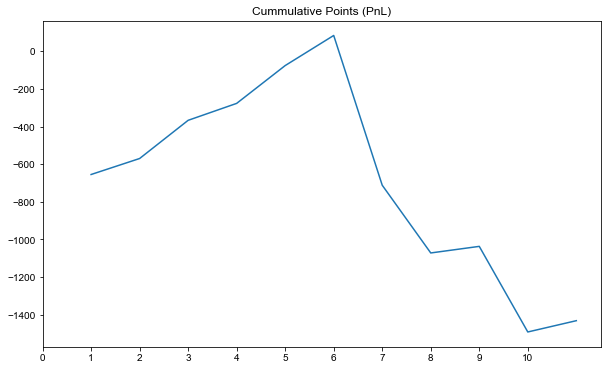

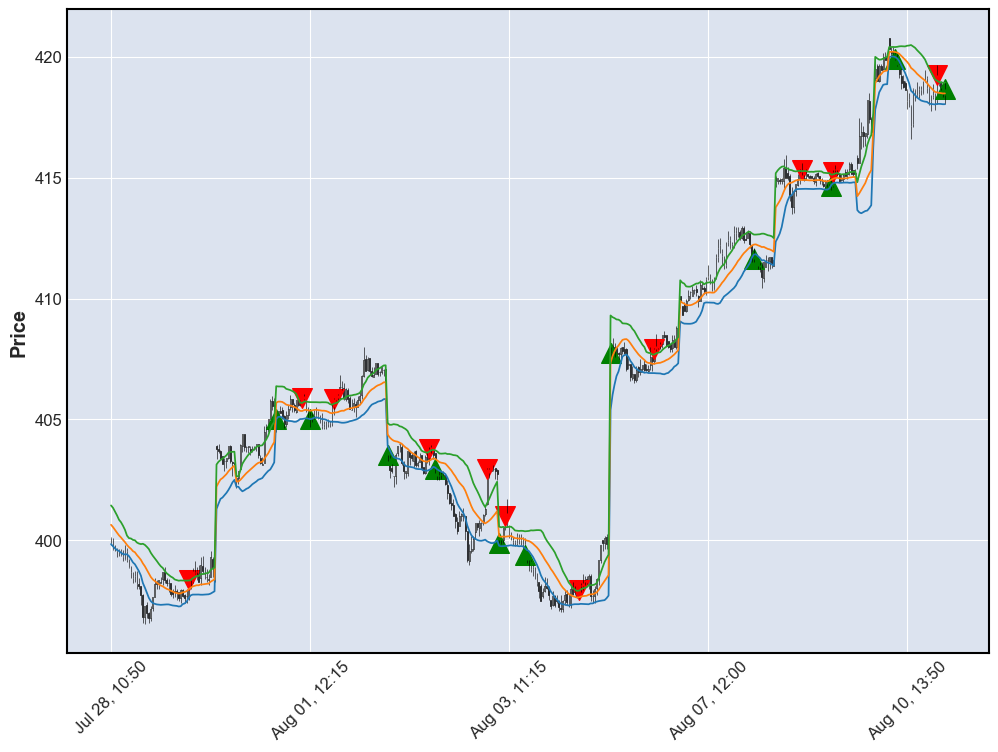

----------


In [3]:
# Only ticker is madatory input to run the code. Rest all have set default values.


if __name__ == "__main__":
    # MeanRevertingStrat( "LT", quantity = 10, stop_loss = 0.01, target_profit = 0.01, std = 2, interval='1T')
    MeanRevertingStrat( "wipro",start_date="2023-07-28 09:15:00",end_date='2023-08-10 15:30:00', quantity = 100, stop_loss = 0.02, target_profit = 0.005, std = 1, interval='5T')

# Format of start_date and end_date variables
# start_date="2023-08-01 09:15:00"
# end_date="2023-08-03 15:30:00"

Exit        11
Stop         1
Last Bar     1
Name: Exit Reason, dtype: int64
                                HDFCBANK
Total Trades                          13
Winners                                9
Losers                                 4
Win %                               69.0
Max Loss                           -16.3
Avg Gain                        3.116667
Avg Loss                         -4.9875
PnL                                810.0
Avg Time       0 days 05:47:18.461538461
Exit Signal                           11
Target Hit                             0
Stop Hit                               1
Last Bar Exit                          1
----------


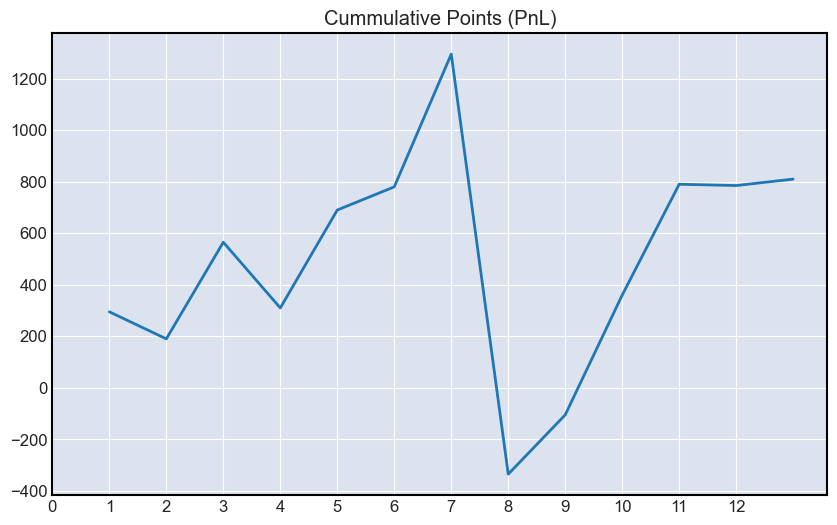

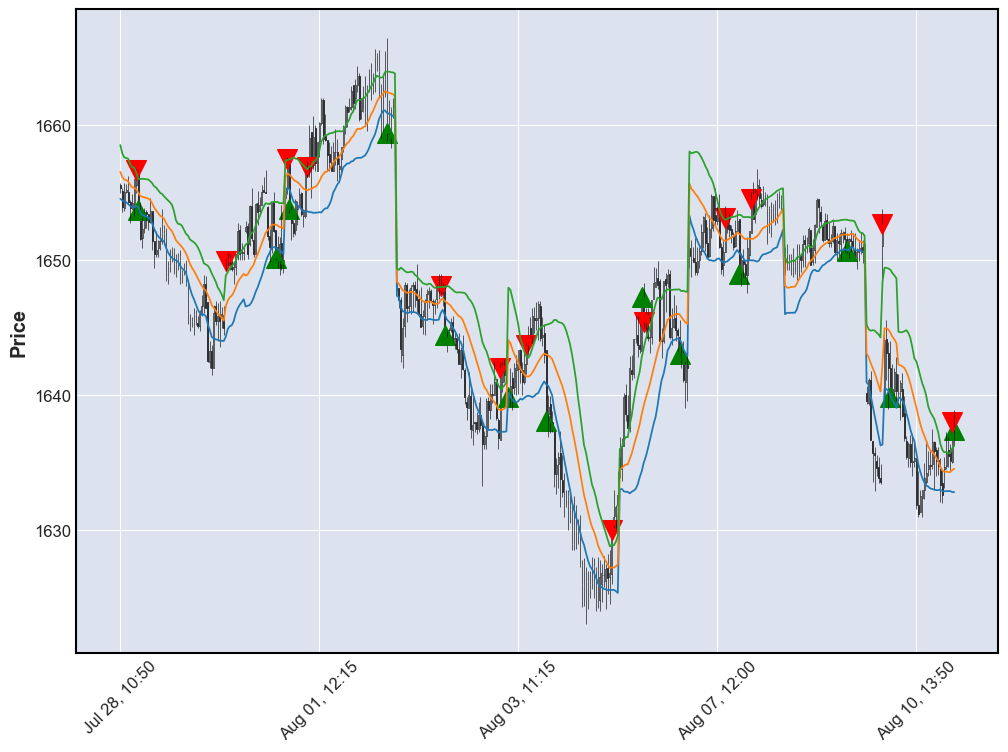

----------


In [4]:
if __name__ == "__main__":
    # MeanRevertingStrat( "LT", quantity = 10, stop_loss = 0.01, target_profit = 0.01, std = 2, interval='1T')
    MeanRevertingStrat( "HDFCBANK",start_date="2023-07-28 09:15:00",end_date='2023-08-10 15:30:00', quantity = 100, stop_loss = 0.01, target_profit = 0.01, std = 1, interval='5T')